# PAGA for hematopoiesis in mouse [(Paul *et al.*, 2015)](https://doi.org/10.1016/j.cell.2015.11.013)

Hematopoiesis: trace myeloid and erythroid differentiation for data of [Paul *et al.* (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

This is the subsampled notebook for testing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
results_file_denoised = './write/paul15_denoised.h5ad'

scanpy==1.3.2+92.g0e0f407 anndata==0.6.13 numpy==1.14.5 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
sc.settings.set_figure_params(dpi=80, frameon=False)  # low dpi (dots per inch) yields small inline figures

In [3]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical


In [4]:
sc.pp.subsample(adata, n_obs=200)

In [5]:
del adata.uns['iroot']

In [6]:
adata.X = adata.X.astype('float64')

## Preprocessing and Visualization

In [7]:
sc.pp.recipe_zheng17(adata)

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 
Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 
Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 
Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


running recipe zheng17
filtered out 59 genes that are detected in less than 1 counts
    finished (0:00:00.06)


In [8]:
sc.tl.pca(adata, svd_solver='arpack')

In [9]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:03.41) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fa"
    finished (0:00:00.42) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


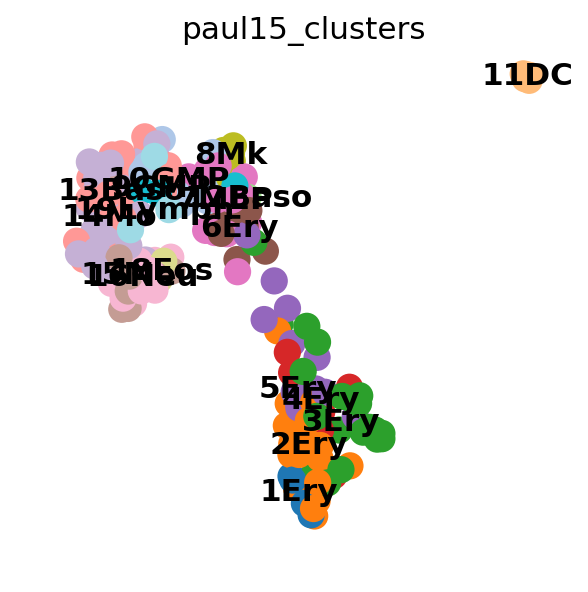

In [10]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This looks a lot like a mess.

In [11]:
adata.write(results_file)

## Denoising the graph

Now, recompute the graph using diffusion maps. Truncating at a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components; this is very similar to denoising a data matrix using PCA.

Note that this is *not* a required step, you might just as well go ahead with a non-denoised graph. In many situations (also here), this will give you very decent results. Sometimes, denoising can remove too much structure.

In [12]:
adata_denoised = sc.read(results_file)
sc.tl.diffmap(adata_denoised)
sc.pp.neighbors(adata_denoised, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         1.         0.99301213 0.95996505 0.9524191  0.9259325
     0.92252815 0.8936017  0.88752323 0.8801779  0.8768419  0.86868614
     0.85445696 0.84612346 0.8304954 ]
    finished (0:00:00.01) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing neighbors
    finished (0:00:00.12) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [13]:
sc.tl.draw_graph(adata_denoised)

drawing single-cell graph using layout "fa"
    finished (0:00:00.34) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


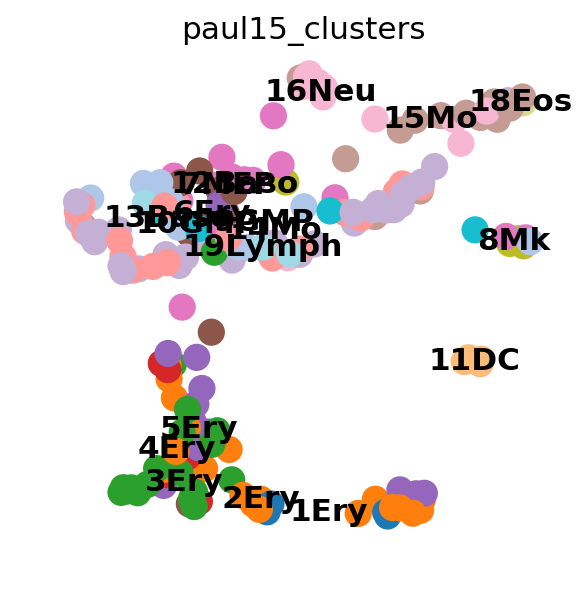

In [14]:
sc.pl.draw_graph(adata_denoised, color='paul15_clusters', legend_loc='on data')

This still looks messy, but in a different way: a lot of the branches are overplotted.

In [15]:
adata_denoised.write(results_file_denoised)

## Clustering and PAGA

In [16]:
adata = sc.read(results_file_denoised)

In [17]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [18]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished (0:00:00.02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


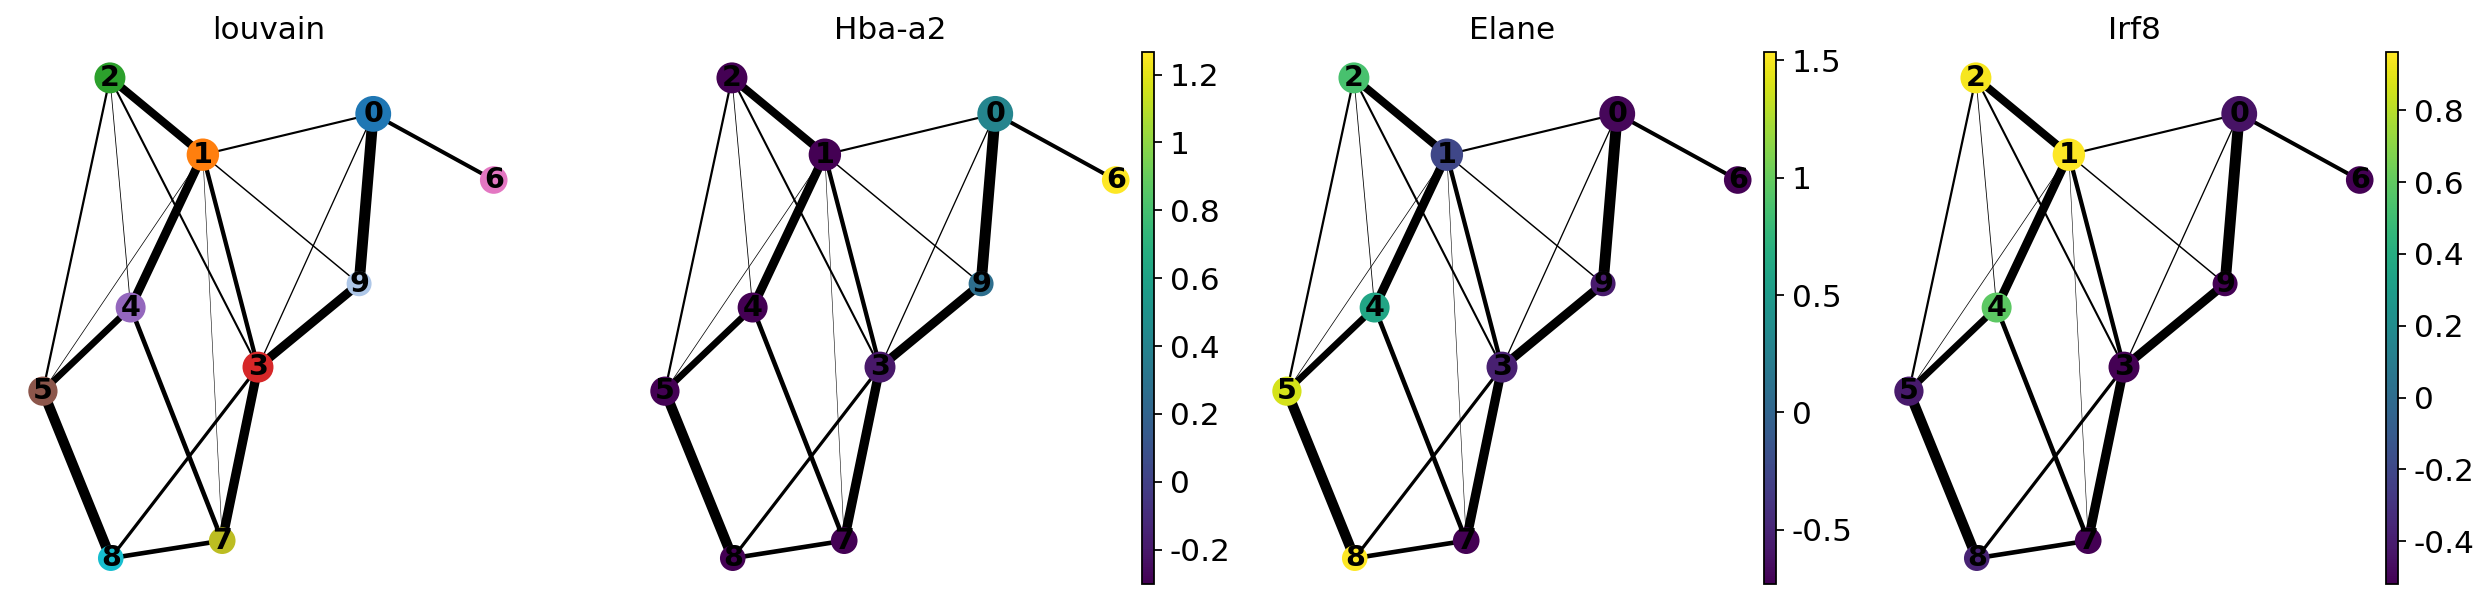

In [19]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


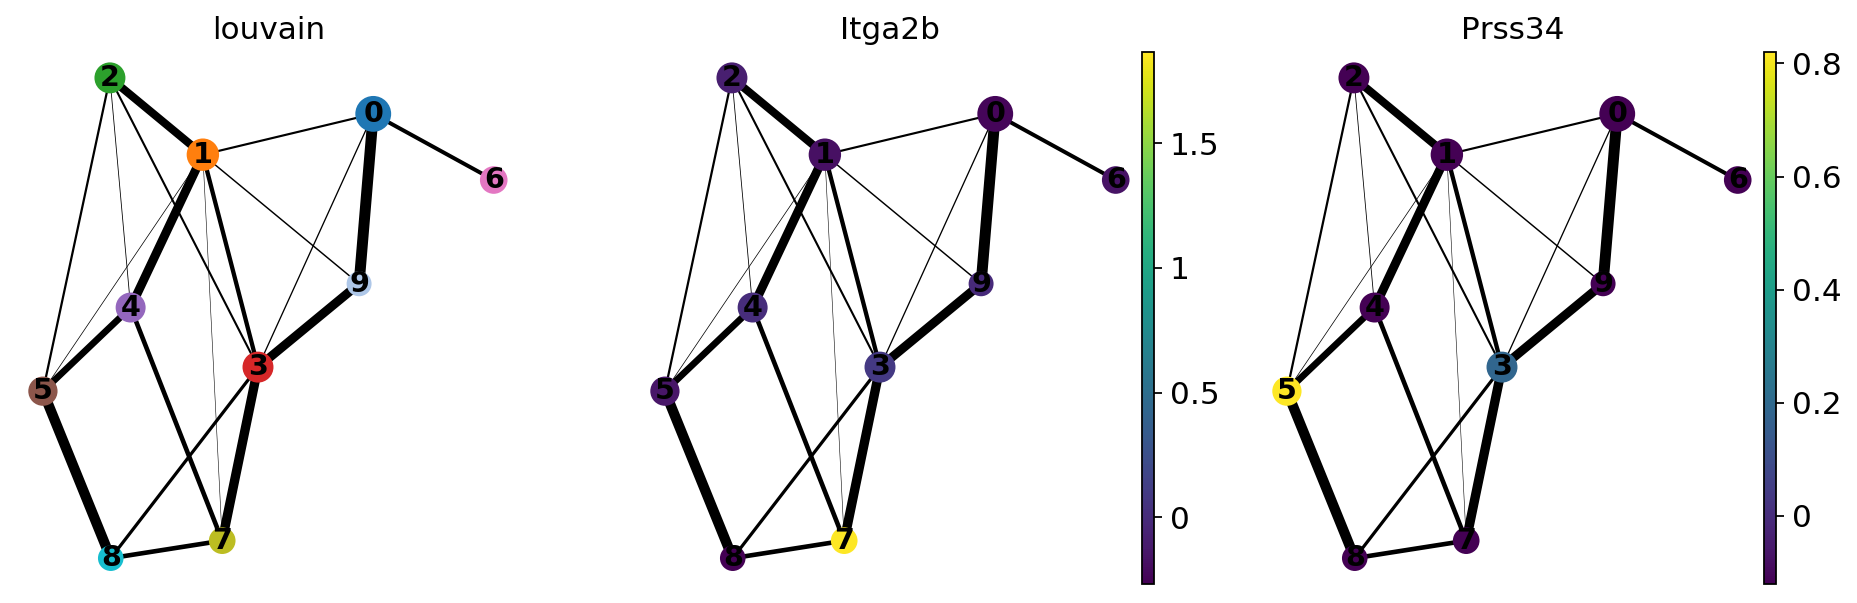

In [20]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34'])

In [21]:
adata.obs['louvain_anno'] = adata.obs['louvain']

Let's use the annotated clusters for PAGA.

In [22]:
sc.tl.paga(adata, groups='louvain_anno')

running PAGA
    finished (0:00:00.02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


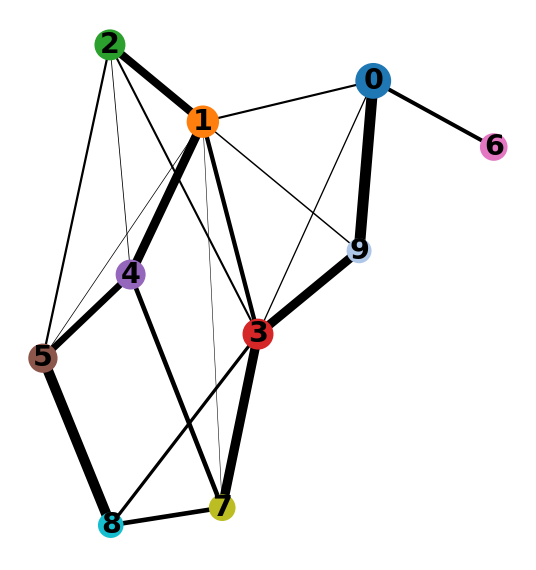

In [23]:
sc.pl.paga(adata, threshold=0.03)

## Recomputing the emnbedding using PAGA-initialization

The following is just as well possible for a UMAP.

In [24]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout "fa"
    finished (0:00:00.36) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


--> added 'pos', the PAGA positions (adata.uns['paga'])


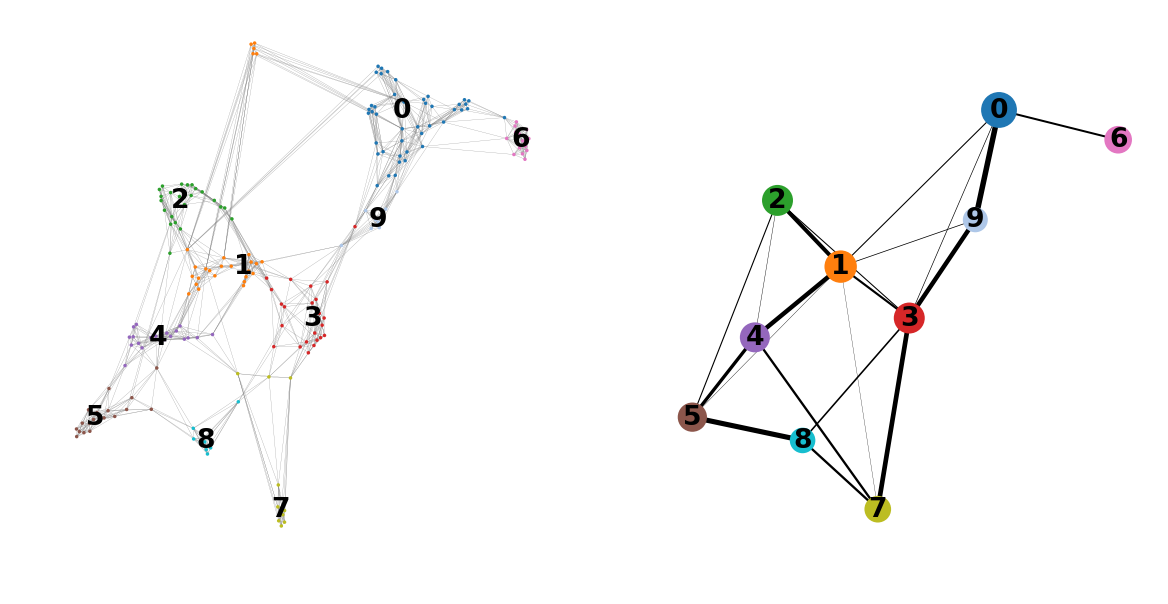

In [25]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True)

In [26]:
adata.write(results_file_denoised)

## Reconstructing gene changes along PAGA paths for a given set of genes

Choose a root cell for diffusion pseudotime.

In [27]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '3')[0]

In [28]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


Select some of the marker gene names.

In [29]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe',                    # neutrophil
              'Irf8']                              # monocyte

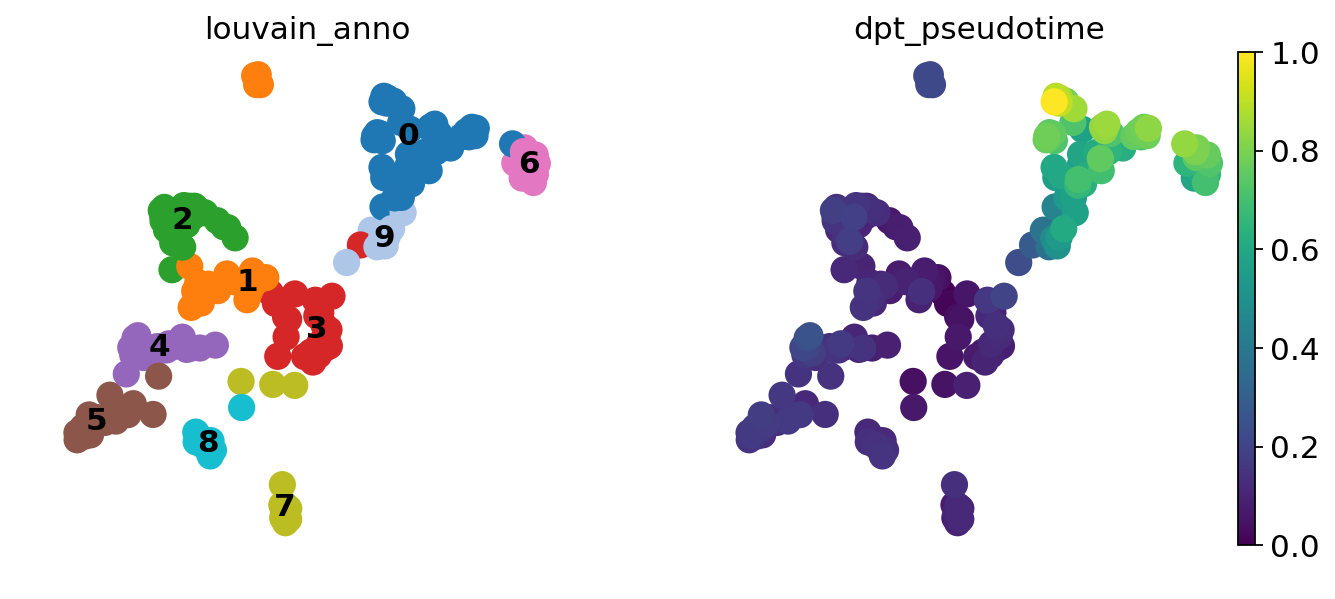

In [30]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [31]:
paths = [('erythrocytes', [3, 9, 0, 6]),
         ('neutrophils', [3, 1, 2]),
         ('monocytes', [3, 1, 4, 5])]

In [32]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

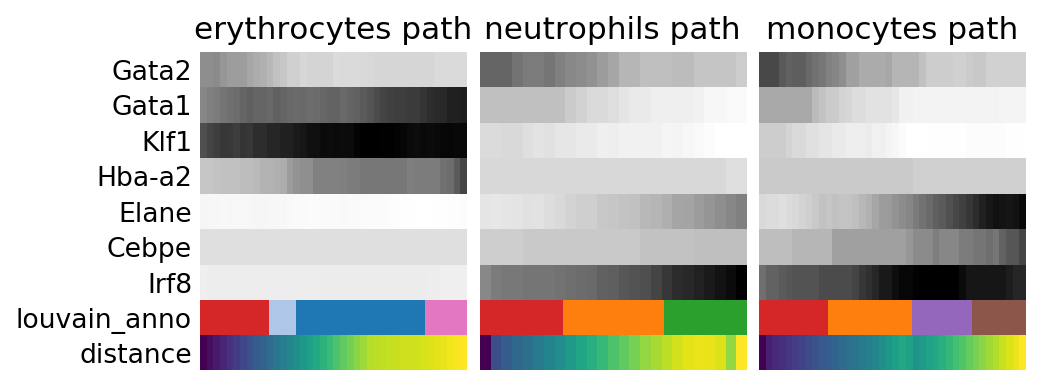

In [33]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.show()